# Melanoma Cancer Detection

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Dataset reading

In [2]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, BatchNormalization, Dropout

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pathlib
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/DataSet/CNN_assignment.zip

Archive:  /content/drive/MyDrive/DataSet/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  in

In [5]:
!ls

 drive	      'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


In [6]:
data_train_dir = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_test_dir = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

print(data_train_dir)
print(data_test_dir)

Skin cancer ISIC The International Skin Imaging Collaboration/Train
Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [7]:
train_image_len = len(list(data_train_dir.glob('*/*.jpg')))
test_image_len = len(list(data_test_dir.glob('*/*.jpg')))
print(train_image_len)
print(test_image_len)

2239
118


### Dataset Creation

- We have data for 9 categories and combined the train and test i.e. total images this dataset has 2357 images.

In [8]:
batch_size = 32
image_width = 180
image_height = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train_dir,
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    image_size = (image_width, image_height),
    batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train_dir,
    seed=123,
    validation_split=0.2,
    subset = "validation",
    image_size = (image_width, image_height),
    batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
class_names = train_ds.class_names
print(train_ds.class_names)
print(val_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


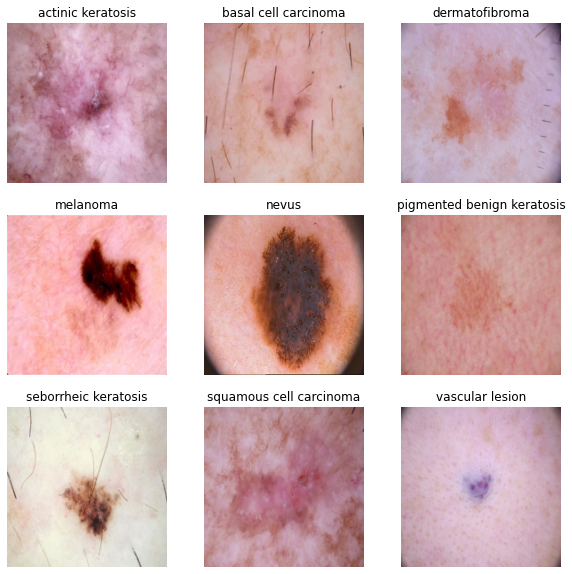

In [12]:
# visualize one instance of all the nine classes present in the dataset 
from PIL import Image

num_class = len(class_names)
total_class_images = []
plt.figure(figsize=(10, 10))

for i in range(num_class):
  ax = plt.subplot(3, 3, i + 1)
  path_dir = pathlib.Path(str(data_train_dir) + '/' + class_names[i])
  names = list(path_dir.glob('*.jpg'))
  idx = np.random.randint(len(names))
  total_class_images.append(len(names))
  #plt.imshow(plt.imread(names[idx]))
  plt.imshow(Image.open(names[idx]).resize((image_width, image_height)))
  plt.title(class_names[i])
  plt.axis('off')
plt.show()

In [13]:
# Use cache() and prefetch() function helps to keep the image data in memory rather read the data from disk eachtime.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Model Building and Training

- Dataset images has RGB channel values are in the [0, 255] range and it's not ideal for a neural network processing. 
- Here it is better standardize values in [0, 1], so we use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1).

In [15]:
# Building the model
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape=(image_width, image_height, 3)))

#First convolutional layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Thrid convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Dropout layer with 50% of input connections to drop
model.add(Dropout(0.5))

#Flatten layer functions flattens the multi-dimensional input tensors to single dimension.
model.add(Flatten())
model.add(Dense(128, activation='relu'))

#Dropout layer with 25% of input connections to drop
model.add(Dropout(0.25))

#Dense layer with softmax
model.add(Dense(num_class))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [17]:
# Fit the model
epochs = 20
history = model.fit(train_ds, 
          batch_size=batch_size,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/20
56/56 [==============================] - 77s 1s/step - loss: 1.9859 - accuracy: 0.2868 - val_loss: 1.7452 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 60s 1s/step - loss: 1.7089 - accuracy: 0.3873 - val_loss: 1.5611 - val_accuracy: 0.4765
Epoch 3/20
56/56 [==============================] - 58s 1s/step - loss: 1.5398 - accuracy: 0.4431 - val_loss: 1.4499 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 62s 1s/step - loss: 1.4078 - accuracy: 0.5073 - val_loss: 1.3528 - val_accuracy: 0.5459
Epoch 5/20
56/56 [==============================] - 59s 1s/step - loss: 1.3992 - accuracy: 0.5218 - val_loss: 1.3561 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 60s 1s/step - loss: 1.3083 - accuracy: 0.5446 - val_loss: 1.3586 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 63s 1s/step - loss: 1.3136 - accuracy: 0.5407 - val_loss: 1.3422 - val_accuracy: 0.5391
Epoch 8/20
56/56 [==

### Visualise the model

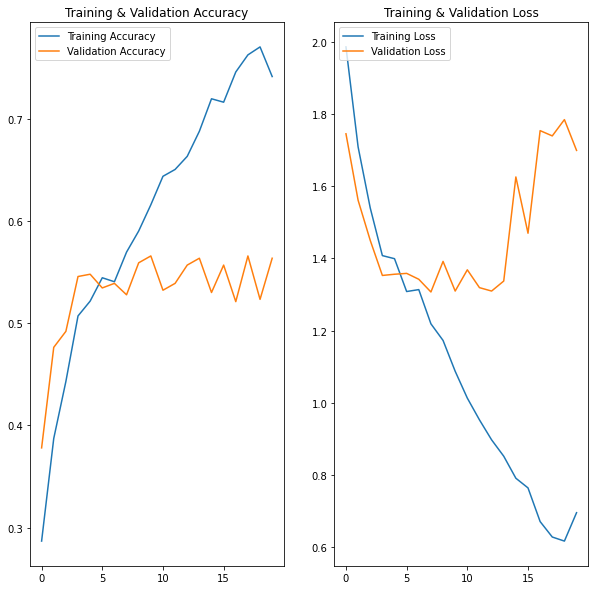

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training & Validation Loss')
plt.show()

Result observation: 

- From the above result and the graph **we can infer that the model is overfitting**. 

- And there is scope that model performace can be improved by synthesisng the data (using techinques like data augmentation). 

- We will build the new model to imporve the performance utilising data augmentation.

### Model Building using Augmented data.

In [19]:
# Generate the augmentated data
data_augmentation = Sequential()

data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', input_shape=(image_width, image_height, 3)))
data_augmentation.add(layers.experimental.preprocessing.RandomRotation(factor = 0.2))
data_augmentation.add(layers.experimental.preprocessing.RandomZoom(0.15))

In [20]:
# Build the model 
model = Sequential()

#added layers to augument data
model.add(data_augmentation)

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape=(image_width, image_height, 3)))

#First convolutional layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Thrid convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Dropout layer with 50% of input connections to drop
model.add(Dropout(0.5))

#Flatten layer functions flattens the multi-dimensional input tensors to single dimension.
model.add(Flatten())
model.add(Dense(128, activation='relu'))

#Dropout layer with 25% of input connections to drop
model.add(Dropout(0.25))

#Dense layer with softmax
model.add(Dense(num_class))

#print(model.summary())

In [21]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [22]:
# Fit the model
epochs = 20
history = model.fit(train_ds, 
          batch_size=batch_size,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/20
56/56 [==============================] - 78s 1s/step - loss: 2.0345 - accuracy: 0.2662 - val_loss: 1.7988 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 73s 1s/step - loss: 1.7336 - accuracy: 0.3839 - val_loss: 1.5798 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 69s 1s/step - loss: 1.5963 - accuracy: 0.4302 - val_loss: 1.4807 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 68s 1s/step - loss: 1.5090 - accuracy: 0.4693 - val_loss: 1.4384 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 69s 1s/step - loss: 1.4327 - accuracy: 0.4877 - val_loss: 1.4418 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 67s 1s/step - loss: 1.4572 - accuracy: 0.4860 - val_loss: 1.4223 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 67s 1s/step - loss: 1.4033 - accuracy: 0.5011 - val_loss: 1.3988 - val_accuracy: 0.5235
Epoch 8/20
56/56 [==

### Visualise the model (generated using augmented data)

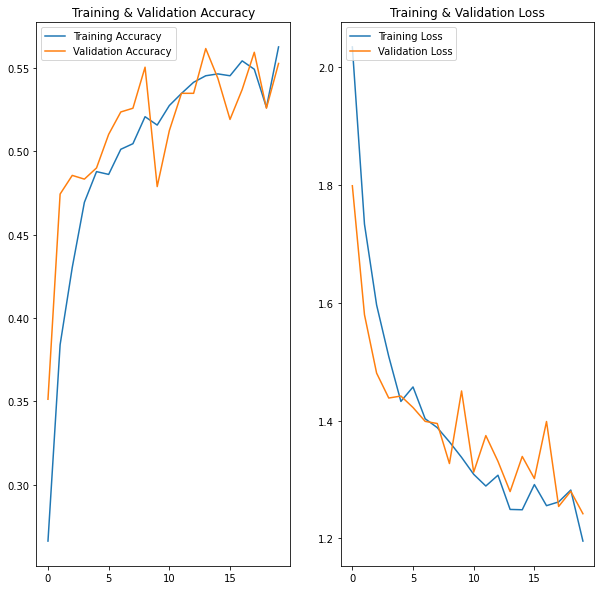

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training & Validation Loss')
plt.show()

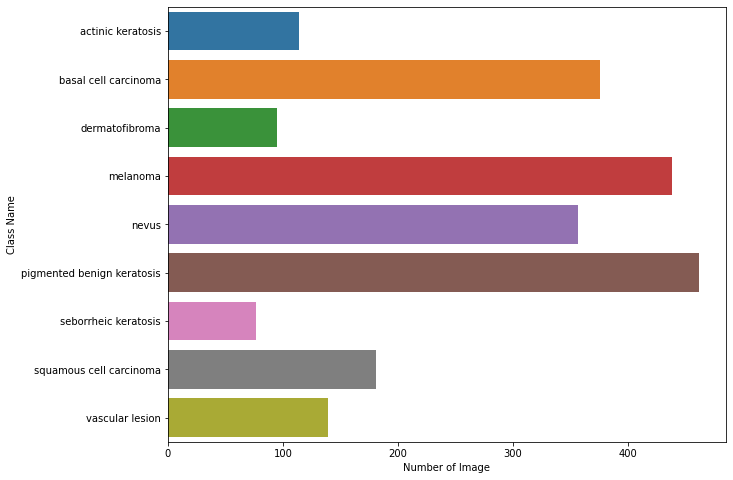

In [38]:
#class has the least number of samples & lcasses dominate the data in terms of the proportionate number of samples
import pandas as pd 
import seaborn as sns

df = pd.DataFrame(list(zip(class_names, total_class_images)), columns=['Class Name', 'Number of Image'])

plt.figure(figsize=(10, 8))
sns.barplot(x = df.columns[1], y = df.columns[0], data=df)
plt.show()

Result observation: 

- From the above result and the graphs, **we find that though the model overfitting is resolved but still the prediction performance is inconsistent**. 

- So, we infer due to dataset dominance, the performance  is varying and not improved. We will try to create equal number of dataset using Augmentor and build a new model.

### Use Augmentor (to handle class imbalance) and Build the model

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
#  Augment the data and create class balance using Augmentor
import Augmentor

dataset_path = str(data_train_dir) + '/'

print(class_names)
for name in class_names:
  print(dataset_path + name)
  pl = Augmentor.Pipeline(dataset_path + name)
  pl.rotate(probability=0.6, max_left_rotation=7, max_right_rotation=7)
  pl.sample(500)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB41FB66A90>: 100%|██████████| 500/500 [00:19<00:00, 25.97 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB48F7E4C40>: 100%|██████████| 500/500 [00:19<00:00, 25.60 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB41AEC4640>: 100%|██████████| 500/500 [00:18<00:00, 27.02 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FB41ECEDD90>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FB41FDFAFA0>: 100%|██████████| 500/500 [01:34<00:00,  5.31 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB41FE35F10>: 100%|██████████| 500/500 [00:17<00:00, 27.89 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB41FDB6880>: 100%|██████████| 500/500 [00:41<00:00, 12.13 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB41FDAB760>: 100%|██████████| 500/500 [00:17<00:00, 27.87 Samples/s]


Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB41FDC2340>: 100%|██████████| 500/500 [00:22<00:00, 22.21 Samples/s]


### Read the original and augmented data of Train and Validation

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train_dir,
    seed=123,
    validation_split=0.2,
    subset = "validation",
    image_size = (image_width, image_height),
    batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

####Build the model

In [49]:
# Build the model 
model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0, input_shape=(image_width, image_height, 3)))

#First convolutional layer
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Thrid convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Dropout layer with 50% of input connections to drop
model.add(Dropout(0.5))

#Flatten layer functions flattens the multi-dimensional input tensors to single dimension.
model.add(Flatten())
model.add(Dense(128, activation='relu'))

#Dropout layer with 25% of input connections to drop
model.add(Dropout(0.25))

#Dense layer with softmax
model.add(Dense(num_class))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

In [50]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [51]:
# Fit the model
epochs = 30
history = model.fit(train_ds, 
          batch_size=batch_size,
          validation_data=val_ds,
          epochs=epochs)

Epoch 1/30
169/169 [==============================] - 224s 1s/step - loss: 1.9087 - accuracy: 0.2706 - val_loss: 1.5537 - val_accuracy: 0.3875
Epoch 2/30
169/169 [==============================] - 180s 1s/step - loss: 1.5283 - accuracy: 0.4043 - val_loss: 1.3575 - val_accuracy: 0.4722
Epoch 3/30
169/169 [==============================] - 179s 1s/step - loss: 1.3499 - accuracy: 0.4894 - val_loss: 1.1704 - val_accuracy: 0.5464
Epoch 4/30
169/169 [==============================] - 178s 1s/step - loss: 1.2018 - accuracy: 0.5519 - val_loss: 1.1173 - val_accuracy: 0.5687
Epoch 5/30
169/169 [==============================] - 179s 1s/step - loss: 1.1049 - accuracy: 0.5822 - val_loss: 1.0261 - val_accuracy: 0.6184
Epoch 6/30
169/169 [==============================] - 179s 1s/step - loss: 0.9754 - accuracy: 0.6348 - val_loss: 0.9423 - val_accuracy: 0.6399
Epoch 7/30
169/169 [==============================] - 177s 1s/step - loss: 0.8910 - accuracy: 0.6652 - val_loss: 0.8891 - val_accuracy: 0.6845

### Visualize the model (with original data and data generated from Augmentor)

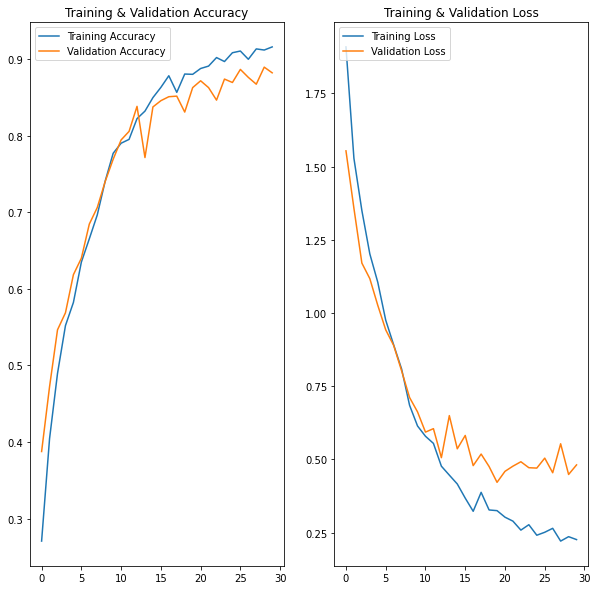

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training & Validation Loss')
plt.show()

Result observation: 

- From the above graphs, we infer that augmentation helps to **resolve the overfitting** issue and get the **best test and training accuracy**. 


### Prediction

In [126]:
class_id = np.random.randint(num_class)
class_name = class_names[class_id]

class_test_image_names = list(data_test_dir.glob(class_name + '/'+ '*.jpg'))

image_id = np.random.randint(len(class_test_image_names))
image_name = class_test_image_names[image_id]

#print(image_name)
img = tf.keras.utils.load_img(class_test_image_names[image_id], target_size=(image_width, image_height, 3))
pred = model.predict(np.expand_dims(img, axis = 0))
pred = np.argmax(pred)

print('Actual class: ', class_name)
print('Predictive class: ', class_names[pred])

1/1 [==============================] - 0s 28ms/step
Actual class:  pigmented benign keratosis
Predictive class:  pigmented benign keratosis


-----